In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())


def get_pig_model_atlas_old():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,251]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,7]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_FULL_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_4_8_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,6]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_4_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas_new():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,103]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6_new", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_olfactory_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_4_6_96_olfactory", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-05-06 16:07:34.148625: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-06 16:07:34.148786: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cubic-login3
2025-05-06 16:07:34.148820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cubic-login3
2025-05-06 16:07:34.149050: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.73.1
2025-05-06 16:07:34.149130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
2025-05-06 16:07:34.149147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.73.1


In [2]:
k1=6
k2=6
validation_folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
# combined_model = get_pig_model_atlas_old()
combined_model = get_pig_model_atlas_new()
combined_model_128 = combined_model
combined_model_96 = combined_model #0get_pig_model_96()
# combined_model_olfactory_96 = get_pig_model_olfactory_96()

model is loading
models_gmm_seg_atlas_6_6_new/weights_epoch_260.h5


[DEBUG] NiftiArrayIO.load(): no header extensions found!

[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)
prediction shape:  (192, 192, 192, 103) 102


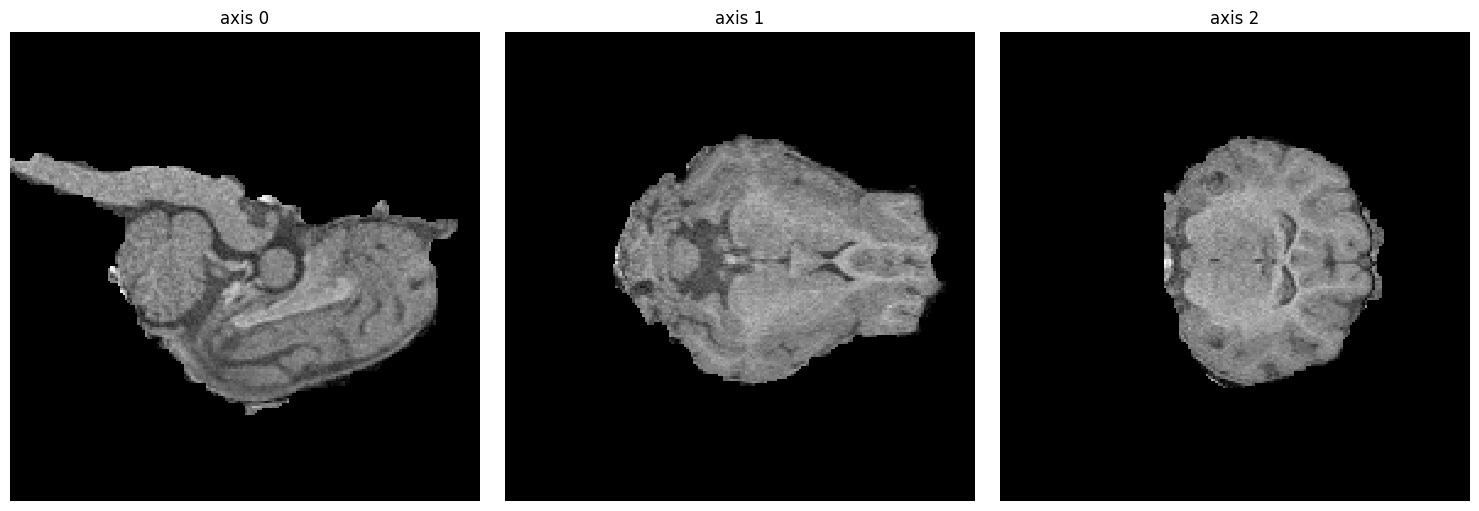

Initial Prediction Result:
first step:  81.61003978786573
first step:  81.61003978786573


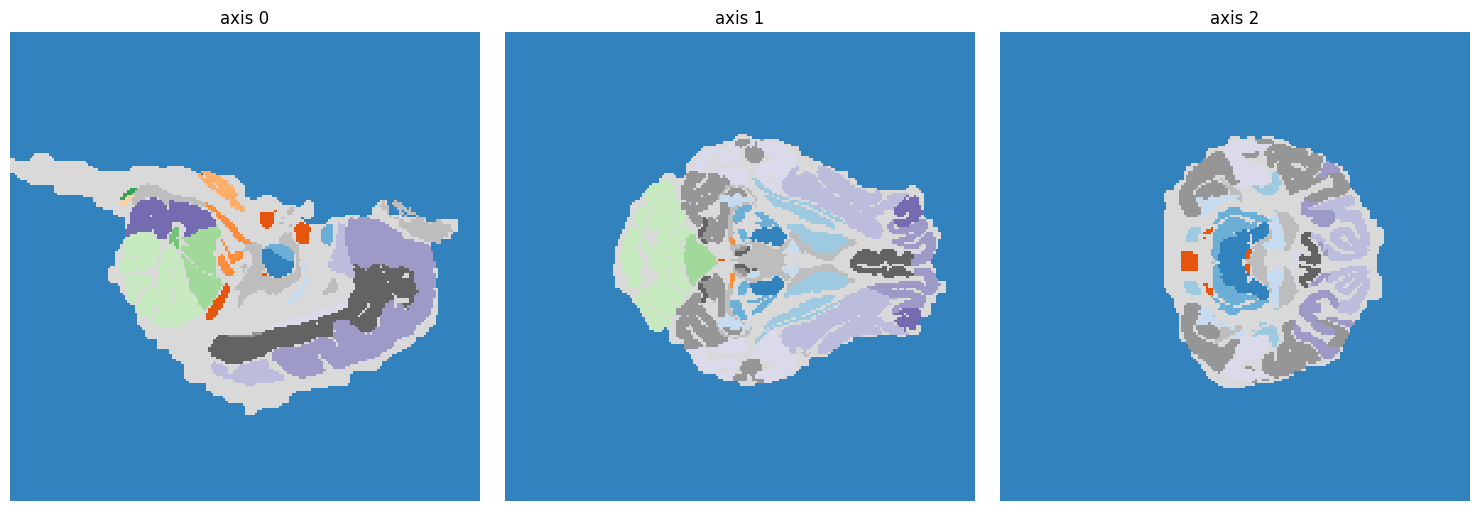

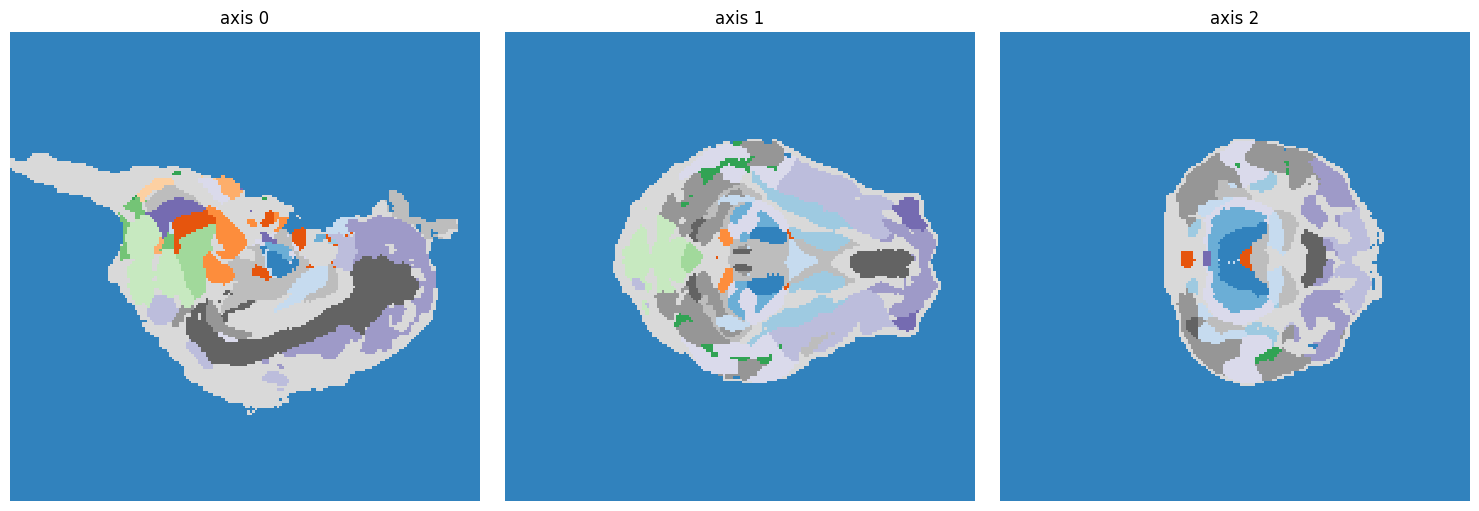

In [3]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import SimpleITK as sitk  # Import SimpleITK for image registration


# validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
# validation_folder_path = "results"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
# combined_model = get_pig_model(k1,k2)
# combined_model_128 = get_pig_model_128()
folder_path = validation_folder_path

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask

def refine_prediction2(crop_img, mask, image, model, model_128,model_96, folder_path, new_image_size=(192, 192, 192), margin=0, cube_size=128):
    # folder_path = os.path.join("results", folder)
    orig_shape = image.shape
    voxsize = image.geom.voxsize
    affine = np.array(image.geom.vox2world)

    os.makedirs(folder_path, exist_ok=True)
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    print(crop_img.shape)

    prediction_one_hot = model.predict(crop_img[None, ...], verbose=0)[0]
    print("prediction shape: ",prediction_one_hot.shape,np.max(np.argmax(prediction_one_hot, axis=-1)))
    initial_prediction = np.argmax(prediction_one_hot, axis=-1)
    ne.plot.volume3D(crop_img, slice_nos=ms)
    print("Initial Prediction Result:")
    print("first step: ",my_hard_dice(mask.data, initial_prediction))
    # nib.save(nib.Nifti1Image(initial_prediction.astype(np.int32), np.eye(4)), os.path.join(folder_path, 'prediction_seg.nii.gz'))
    nib.save(nib.Nifti1Image(sf.Volume(initial_prediction.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'prediction_seg.nii.gz'))

    print("first step: ",my_hard_dice(mask.data, initial_prediction))
    return initial_prediction


dice_scores = []

new_voxsize = [1, 1, 1]

import numpy as np
        
filename = os.path.join(validation_folder_path, f"anat_brain.nii.gz")
mask_filename = os.path.join(folder_path, f"anat_brain_atlas102.nii.gz")

# Load mask
if not os.path.isfile(mask_filename):
    mask = sf.Volume(np.ones((192, 192, 192)))
else:
    mask = sf.load_volume(mask_filename).resize(new_voxsize, method="linear")
    mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])


print()
# Load and process image
image = sf.load_volume(filename)
crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])

# Binarize the mask
# mask.data[mask.data != 0] = 1

# Compute mask center
ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)

prediction = refine_prediction2(crop_img, mask, image, combined_model,combined_model_128,combined_model_96, folder_path, new_image_size=(192, 192, 192))

ne.plot.volume3D(mask, slice_nos=ms,cmaps=['tab20c'])
ne.plot.volume3D(prediction, slice_nos=ms,cmaps=['tab20c'])
# Compute Dice coefficient
mask_flat = mask.data.flatten()
prediction_flat = prediction.flatten()
dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))

dice_scores.append(dice_score)
overall_dice = np.mean(dice_scores)

nib.save(nib.Nifti1Image(prediction.astype(np.int32), np.eye(4)),os.path.join("synth_data", 'prediction_atlas_mask.nii.gz'))


Found 3111 event files.


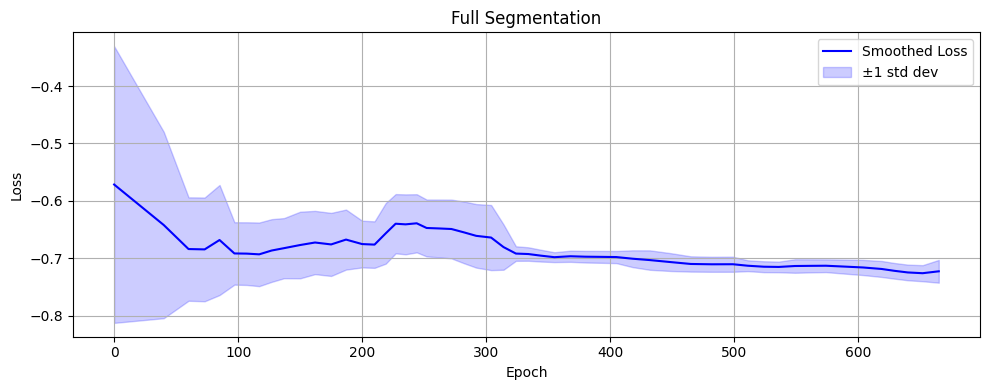

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = "logs_gmm_seg_atlas_6_6_new/train/"
all_steps = []
all_values = []

# Load all events
event_files = [
    os.path.join(log_dir, f)
    for f in os.listdir(log_dir)
    if f.startswith("events.out.tfevents")
]

print(f"Found {len(event_files)} event files.")

for file in event_files:
    try:
        ea = EventAccumulator(file)
        ea.Reload()
        if "loss" not in ea.Tags().get("tensors", []):
            continue
        for e in ea.Tensors("loss"):
            val = tf.make_ndarray(e.tensor_proto).item()
            if not (tf.math.is_nan(val) or tf.math.is_inf(val)):
                all_steps.append(e.step)
                all_values.append(val)
    except Exception as err:
        print(f"Skipping {file}: {err}")

# Sort and subsample
combined = sorted(zip(all_steps, all_values), key=lambda x: x[0])
steps, values = zip(*combined) if combined else ([], [])

# Subsample every 50 points
steps_sub = steps[::50]
values_sub = values[::50]

# Smooth with moving average
window = 10
smooth_values = np.convolve(values_sub, np.ones(window)/window, mode='valid')
smooth_steps = steps_sub[:len(smooth_values)]

# Compute standard deviation over rolling window
rolling_std = [np.std(values_sub[i:i+window]) for i in range(len(smooth_values))]
upper = smooth_values + rolling_std
lower = smooth_values - rolling_std

# Plot with shaded variance
plt.figure(figsize=(10, 4))
plt.plot(smooth_steps, smooth_values, label="Smoothed Loss", color='blue')
plt.fill_between(smooth_steps, lower, upper, color='blue', alpha=0.2, label='±1 std dev')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Full Segmentation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("smoothed_loss_with_variance.png")
plt.show()


In [9]:
nib.save(nib.Nifti1Image(crop_img.astype(np.float32), np.eye(4)),os.path.join("synth_data", 'atlas_192.nii.gz'))


In [5]:
folder_path

'/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/'